# CS 7641 - HW1 Supervised Learning (Hotel)

Decision Trees. For the decision tree, you should implement or steal a decision tree algorithm (and by "implement or steal" I mean "steal"). Be sure to use some form of pruning. You are not required to use information gain (for example, there is something called the GINI index that is sometimes used) to split attributes, but you should describe whatever it is that you do use.

Neural Networks. For the neural network you should implement or steal your favorite kind of network and training algorithm. You may use networks of nodes with as many layers as you like and any activation function you see fit.

Boosting. Implement or steal a boosted version of your decision trees. As before, you will want to use some form of pruning, but presumably because you're using boosting you can afford to be much more aggressive about your pruning.

Support Vector Machines. You should implement (for sufficiently loose definitions of implement including "download") SVMs. This should be done in such a way that you can swap out kernel functions. I'd like to see at least two.

k-Nearest Neighbors. You should "implement" (the quotes mean I don't mean it: steal the code) kNN. Use different values of k.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import matplotlib.pyplot as plt

from sklearn.model_selection import learning_curve
from sklearn.model_selection import validation_curve
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import LabelEncoder


from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

from sklearn.metrics import accuracy_score, precision_score,recall_score

import time


In [2]:
## Code Snippet From Sklearn Tutorial : https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html#sphx-glr-auto-examples-model-selection-plot-learning-curve-py

def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    scoring=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    """
    Generate 3 plots: the test and training learning curve, the training
    samples vs fit times curve, the fit times vs score curve.

    Parameters
    ----------
    estimator : estimator instance
        An estimator instance implementing `fit` and `predict` methods which
        will be cloned for each validation.

    title : str
        Title for the chart.

    X : array-like of shape (n_samples, n_features)
        Training vector, where ``n_samples`` is the number of samples and
        ``n_features`` is the number of features.

    y : array-like of shape (n_samples) or (n_samples, n_features)
        Target relative to ``X`` for classification or regression;
        None for unsupervised learning.

    axes : array-like of shape (3,), default=None
        Axes to use for plotting the curves.

    ylim : tuple of shape (2,), default=None
        Defines minimum and maximum y-values plotted, e.g. (ymin, ymax).

    cv : int, cross-validation generator or an iterable, default=None
        Determines the cross-validation splitting strategy.
        Possible inputs for cv are:

          - None, to use the default 5-fold cross-validation,
          - integer, to specify the number of folds.
          - :term:`CV splitter`,
          - An iterable yielding (train, test) splits as arrays of indices.

        For integer/None inputs, if ``y`` is binary or multiclass,
        :class:`StratifiedKFold` used. If the estimator is not a classifier
        or if ``y`` is neither binary nor multiclass, :class:`KFold` is used.

        Refer :ref:`User Guide <cross_validation>` for the various
        cross-validators that can be used here.

    n_jobs : int or None, default=None
        Number of jobs to run in parallel.
        ``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.
        ``-1`` means using all processors. See :term:`Glossary <n_jobs>`
        for more details.

    scoring : str or callable, default=None
        A str (see model evaluation documentation) or
        a scorer callable object / function with signature
        ``scorer(estimator, X, y)``.

    train_sizes : array-like of shape (n_ticks,)
        Relative or absolute numbers of training examples that will be used to
        generate the learning curve. If the ``dtype`` is float, it is regarded
        as a fraction of the maximum size of the training set (that is
        determined by the selected validation method), i.e. it has to be within
        (0, 1]. Otherwise it is interpreted as absolute sizes of the training
        sets. Note that for classification the number of samples usually have
        to be big enough to contain at least one sample from each class.
        (default: np.linspace(0.1, 1.0, 5))
    """
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        scoring=scoring,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )
    axes[0].plot(
        train_sizes, test_scores_mean, "o-", color="g", label="Cross-validation score"
    )
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    fit_time_argsort = fit_times_mean.argsort()
    fit_time_sorted = fit_times_mean[fit_time_argsort]
    test_scores_mean_sorted = test_scores_mean[fit_time_argsort]
    test_scores_std_sorted = test_scores_std[fit_time_argsort]
    axes[2].grid()
    axes[2].plot(fit_time_sorted, test_scores_mean_sorted, "o-")
    axes[2].fill_between(
        fit_time_sorted,
        test_scores_mean_sorted - test_scores_std_sorted,
        test_scores_mean_sorted + test_scores_std_sorted,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

# Import Data

In [71]:
hotel = pd.read_csv('Data/HotelBooking.csv')

In [72]:
hotel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [73]:
hotel.head().transpose()

,0,1,2,3,4
hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel,Resort Hotel
is_canceled,0,0,0,0,0
lead_time,342,737,7,13,14
arrival_date_year,2015,2015,2015,2015,2015
arrival_date_month,July,July,July,July,July
arrival_date_week_number,27,27,27,27,27
arrival_date_day_of_month,1,1,1,1,1
stays_in_weekend_nights,0,0,0,0,0
stays_in_week_nights,0,0,1,1,2
adults,2,2,1,1,2


In [74]:
hotel = hotel.sample(frac =.2)

In [75]:
hotel.groupby('is_canceled').count()

,hotel,lead_time,arrival_date_year,arrival_date_month,arrival_date_week_number,arrival_date_day_of_month,stays_in_weekend_nights,stays_in_week_nights,adults,children,...,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,reservation_status_date,name,email,phone-number,credit_card
is_canceled,,,,,,,,,,,,,,,,,,,,,
0,14953,14953,14953,14953,14953,14953,14953,14953,14953,14953,...,14953,14953,14953,14953,14953,14953,14953,14953,14953,14953
1,8925,8925,8925,8925,8925,8925,8925,8925,8925,8925,...,8925,8925,8925,8925,8925,8925,8925,8925,8925,8925


# Pre-processing

In [76]:
categorical_columns = hotel.columns[hotel.dtypes == 'object'].drop(['reservation_status', 'reservation_status_date', 'name', 'email',
       'phone-number', 'credit_card'])
for i in categorical_columns:
    print(hotel.groupby(i).hotel.count())
    print('\n')

hotel
City Hotel      15874
Resort Hotel     8004
Name: hotel, dtype: int64


arrival_date_month
April        2253
August       2789
December     1325
February     1592
January      1210
July         2537
June         2177
March        1948
May          2350
November     1338
October      2244
September    2115
Name: hotel, dtype: int64


meal
BB           18556
FB             159
HB            2811
SC            2119
Undefined      233
Name: hotel, dtype: int64


country
ABW      1
AGO     77
AIA      1
ALB      2
AND      2
      ... 
URY     10
USA    420
VEN      3
VNM      2
ZAF     14
Name: hotel, Length: 130, dtype: int64


market_segment
Aviation            46
Complementary      139
Corporate         1059
Direct            2522
Groups            3943
Offline TA/TO     4888
Online TA        11281
Name: hotel, dtype: int64


distribution_channel
Corporate     1322
Direct        2897
GDS             44
TA/TO        19614
Undefined        1
Name: hotel, dtype: int64


reserved_room

In [77]:
hotel = (hotel.drop(['reservation_status', 'reservation_status_date', 'name', 'email','phone-number', 'credit_card','agent', 'company'], axis = 1))
hotel.columns

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests'],
      dtype='object')

In [78]:
hotel = pd.get_dummies(hotel, columns = categorical_columns, drop_first=True)

In [79]:
len(hotel)

23878

In [80]:
hotel.columns[hotel.isnull().sum() > 0]

Index([], dtype='object')

In [81]:
hotel.head().transpose()

,35012,5709,51421,94198,52091
is_canceled,0.0,1.0,1.0,0.0,1.0
lead_time,29.0,30.0,322.0,172.0,12.0
arrival_date_year,2017.0,2016.0,2016.0,2016.0,2016.0
arrival_date_week_number,15.0,20.0,21.0,31.0,23.0
arrival_date_day_of_month,10.0,12.0,19.0,26.0,30.0
...,...,...,...,...,...
deposit_type_Non Refund,0.0,0.0,1.0,0.0,0.0
deposit_type_Refundable,0.0,0.0,0.0,0.0,0.0
customer_type_Group,0.0,0.0,0.0,0.0,0.0
customer_type_Transient,1.0,1.0,1.0,1.0,1.0


# Model Run

In [82]:
hotel.columns

Index(['is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_week_number', 'arrival_date_day_of_month',
       'stays_in_weekend_nights', 'stays_in_week_nights', 'adults', 'children',
       'babies',
       ...
       'assigned_room_type_G', 'assigned_room_type_H', 'assigned_room_type_I',
       'assigned_room_type_K', 'assigned_room_type_P',
       'deposit_type_Non Refund', 'deposit_type_Refundable',
       'customer_type_Group', 'customer_type_Transient',
       'customer_type_Transient-Party'],
      dtype='object', length=197)

In [83]:
feature_cols = hotel.columns.drop('is_canceled')
X = hotel[feature_cols]
y = hotel.is_canceled
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# (1)  Decision Tree


In [84]:
dtree = DecisionTreeClassifier()

start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time


start_time = time.time()
y_pred = dtree.predict(X_test)
end_time = time.time()
time_infer = end_time-start_time

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Time Train:", time_train)
print("Time Infer:", time_infer)

Accuracy: 0.8178391959798995
Precision: 0.7543661971830986
Recall: 0.7552171460800903
Time Train: 0.17593812942504883
Time Infer: 0.0029997825622558594


In [90]:

ml_model = DecisionTreeClassifier()
params = {
    'splitter': ['best','random'],
    'criterion': ['gini', 'entropy',],
}

clf = GridSearchCV(estimator=ml_model, param_grid=params, cv=5, n_jobs=5, verbose=1)

clf.fit(X_train, y_train)
print(clf.best_params_)


Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'criterion': 'entropy', 'splitter': 'random'}


In [92]:
dtree = DecisionTreeClassifier(criterion='entropy', splitter = 'random')

start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time


start_time = time.time()
y_pred = dtree.predict(X_test)
end_time = time.time()
time_infer = end_time-start_time

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Time Train:", time_train)
print("Time Infer:", time_infer)

Accuracy: 0.8209798994974874
Precision: 0.755
Recall: 0.766497461928934
Time Train: 0.13398003578186035
Time Infer: 0.0045909881591796875


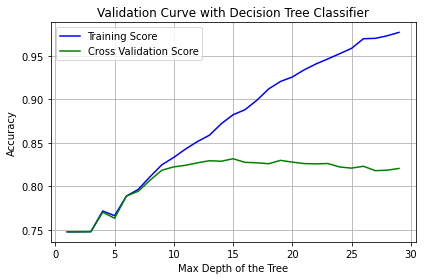

In [91]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(1, 30, 1)
train_score, test_score = validation_curve(DecisionTreeClassifier(criterion= 'entropy', splitter ='random'), X, y,
                                       param_name = "max_depth",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with Decision Tree Classifier")
plt.xlabel("Max Depth of the Tree")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [106]:
np.argmax(mean_test_score) + 1

15

In [107]:
dtree = DecisionTreeClassifier(criterion='entropy', splitter = 'random', max_depth = 15)

start_time = time.time()
dtree.fit(X_train, y_train)
end_time = time.time()
time_train = end_time-start_time


start_time = time.time()
y_pred = dtree.predict(X_test)
end_time = time.time()
time_infer = end_time-start_time

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))
print("Time Train:", time_train)
print("Time Infer:", time_infer)

Accuracy: 0.8358458961474037
Precision: 0.7945205479452054
Recall: 0.7523970671178793
Time Train: 0.19745707511901855
Time Infer: 0.0748910903930664


<module 'matplotlib.pyplot' from '/Users/jiheekim/miniforge3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

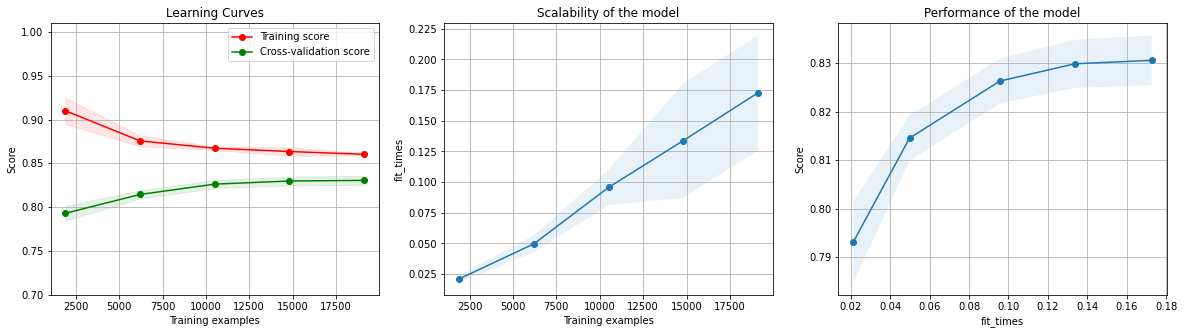

In [108]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = DecisionTreeClassifier(criterion='entropy', splitter = 'random', max_depth = 13)
plot_learning_curve( estimator,  title, X, y, axes=axes[ :], ylim=(0.7, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")


# (2)  Support Vector Machine


In [101]:
clf = SVC()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.6561976549413735
Precision: 0.6139130434782609
Recall: 0.1990975747320925


In [103]:
ml_model = SVC()
params = {
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
}

clf = GridSearchCV(estimator=ml_model, param_grid=params, cv=5, n_jobs=5, verbose=1)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
{'kernel': 'linear'}


In [109]:
clf = SVC(kernel = "linear")
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.8077889447236181
Precision: 0.8301158301158301
Recall: 0.6063169768753525


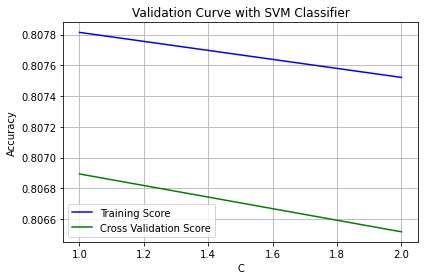

In [110]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(1, 3, 1)
train_score, test_score = validation_curve(SVC(kernel = "linear"), X, y,
                                       param_name = "C",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with SVM Classifier")
plt.xlabel("C")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.grid()
plt.legend(loc = 'best')
plt.show()

In [ ]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = DecisionTreeClassifier()
plot_learning_curve( estimator,  title, x, y, axes=axes[ :], ylim=(0.9, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")


# (3)  K Nearest Neighbors


In [111]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8077889447236181
Precision: 0.8301158301158301
Recall: 0.6063169768753525


In [113]:
ml_model = KNeighborsClassifier()
params = {
    'weights': ['uniform', 'distance'],
}

clf = GridSearchCV(estimator=ml_model, param_grid=params, cv=5, n_jobs=5, verbose=1)

clf.fit(X_train, y_train)
print(clf.best_params_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
{'weights': 'distance'}


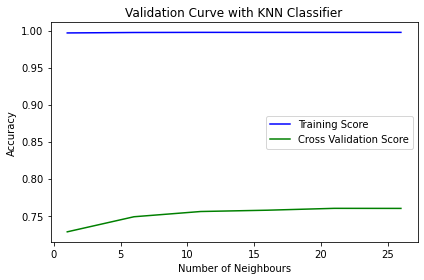

In [121]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(1, 30, 5)
train_score, test_score = validation_curve(KNeighborsClassifier(weights = 'distance'), X, y,
                                       param_name = "n_neighbors",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Number of Neighbours")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

In [122]:
(mean_test_score)

array([0.72824363, 0.74859716, 0.75567454, 0.7574335 , 0.75994629,
       0.75986252])

In [123]:
knn = KNeighborsClassifier(weights = 'distance', n_neighbors= 21)
knn.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:",recall_score(y_test, y_pred))

Accuracy: 0.7552345058626466
Precision: 0.6780660377358491
Recall: 0.6486181613085167


<module 'matplotlib.pyplot' from '/Users/jiheekim/miniforge3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

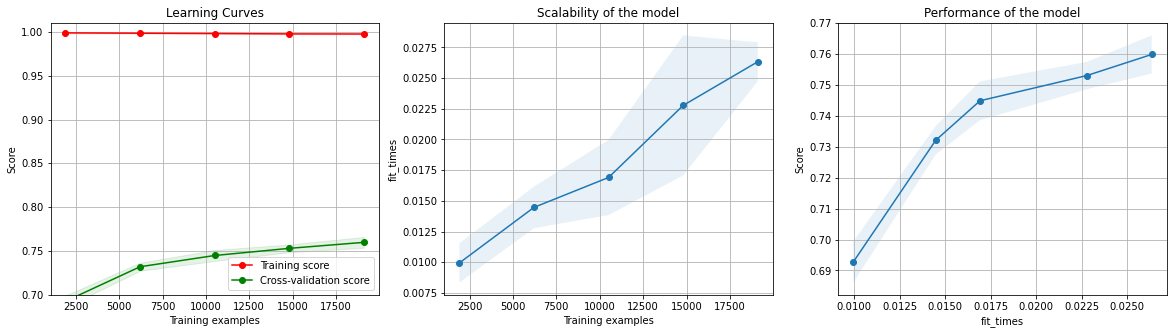

In [128]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator =  KNeighborsClassifier(weights = 'distance', n_neighbors= 21)
plot_learning_curve( estimator,  title, X, y, axes=axes[ :], ylim=(0.7, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")


# (4)  AdaBoost


In [127]:
ada = AdaBoostClassifier()
ada.fit(X_train, y_train)
y_pred = ada.predict(X_test)

print('Accuracy:', accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))

Accuracy: 0.8232830820770519
Precision: 0.8111185532484929
Recall: 0.6830231246474902


/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:615: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 598, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 443, in fit
    return super().fit(X, y, sample_weight)
  File "/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py", line 102, in fit
    raise ValueError("learning_rate must be greater than zero")
ValueError: learning_rate must be greater than zero

  warnings.warn("Estimator fit failed. The score on this train-test"
/Users/jiheekim/miniforge3/lib/python3.9/site-packages/sklearn/model_selection/_valida

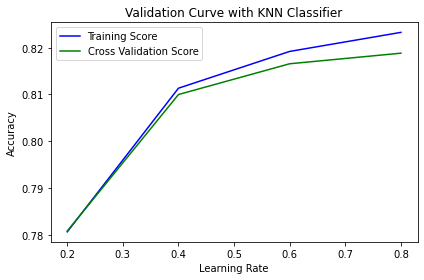

In [129]:
# Source Code : https://www.geeksforgeeks.org/validation-curve/

parameter_range = np.arange(0, 1, 0.2)
train_score, test_score = validation_curve(AdaBoostClassifier(), X, y,
                                       param_name = "learning_rate",
                                       param_range = parameter_range,
                                        cv = 5, scoring = "accuracy")
 
# Calculating mean and standard deviation of training score
mean_train_score = np.mean(train_score, axis = 1)
std_train_score = np.std(train_score, axis = 1)
 
# Calculating mean and standard deviation of testing score
mean_test_score = np.mean(test_score, axis = 1)
std_test_score = np.std(test_score, axis = 1)
 
# Plot mean accuracy scores for training and testing scores
plt.plot(parameter_range, mean_train_score, label = "Training Score", color = 'b')
plt.plot(parameter_range, mean_test_score, label = "Cross Validation Score", color = 'g')
 
# Creating the plot
plt.title("Validation Curve with KNN Classifier")
plt.xlabel("Learning Rate")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.legend(loc = 'best')
plt.show()

<module 'matplotlib.pyplot' from '/Users/jiheekim/miniforge3/lib/python3.9/site-packages/matplotlib/pyplot.py'>

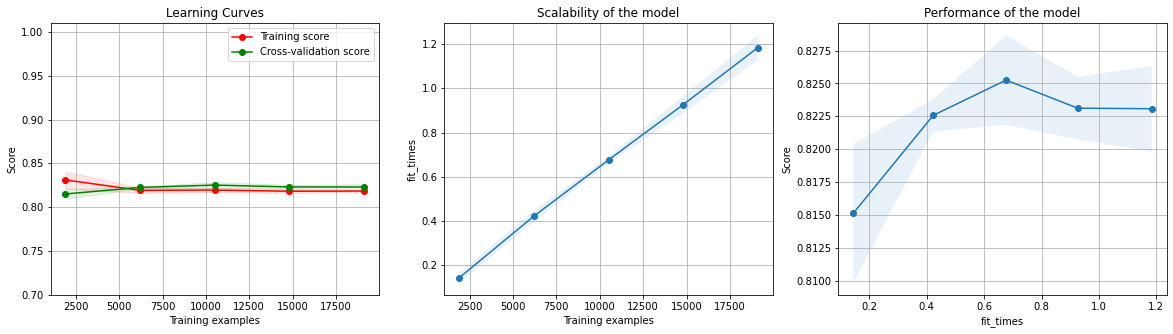

In [132]:
title = "Learning Curves"
# Cross validation with 5 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

estimator = AdaBoostClassifier(learning_rate = 0.6)
plot_learning_curve( estimator,  title, X, y, axes=axes[ :], ylim=(0.7, 1.01), cv=cv,  n_jobs=4, scoring="accuracy")
